In [1]:
import ee
from google.oauth2 import service_account

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geetools
import eemont
import geemap
from ee_extra.TimeSeries.core import getTimeSeriesByRegion

from plot_ee_fctns import get_image_index, box_around_point, mask_other, initialise_comparison
from masks import mask_MODIS_clouds, MODIS_Mask_QC, mask_s2_clouds, mask_s2_clouds_collection, csPlus_mask_collection, MODIS_mask_clouds_250m
import masks

from scipy.interpolate import griddata

# Path to the private key file
key_path = 'Access/ee-martinparker637-e68fde65abb4.json'

# Load the service account credentials
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=['https://www.googleapis.com/auth/earthengine'])

# Initialize Earth Engine with the service account credentials
ee.Initialize(credentials)
root_directory = ''

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [2]:
def thin_daily_daytime(collection, start_hour=6, end_hour=18):
    def unique_date(date):
        date = ee.Date(date)
        # Filter images for this day + daytime constraint
        imgs = collection.filterDate(date, date.advance(1, "day"))
        img = imgs.first()
        return ee.List([img])
    
    start = ee.Date(collection.first().get("system:time_start"))
    end   = ee.Date(collection.sort("system:time_start", False).first().get("system:time_start"))
    n     = end.difference(start, "day").round().toInt()
    dates = ee.List.sequence(0, n).map(lambda d: start.advance(d, "day"))
    
    return ee.ImageCollection(dates.map(unique_date).flatten())

In [3]:
def thin_daily(collection):
    def unique_date(date):
        date = ee.Date(date)
        # Just pick the first image of that day (Landsat always daytime)
        img = collection.filterDate(date, date.advance(1, "day")).first()
        return ee.List([img])
    
    start = ee.Date(collection.first().get("system:time_start"))
    end   = ee.Date(collection.sort("system:time_start", False).first().get("system:time_start"))
    n     = end.difference(start, "day").round().toInt()
    dates = ee.List.sequence(0, n).map(lambda d: start.advance(d, "day"))
    
    return ee.ImageCollection(dates.map(unique_date).flatten())

In [4]:
def thin_daily_existing(collection):
    # Get distinct days that actually exist in the collection
    dates = collection.aggregate_array('system:time_start') \
                     .map(lambda t: ee.Date(t).format('YYYY-MM-dd')) \
                     .distinct()
    
    def per_date(d):
        date = ee.Date(d)
        img = collection.filterDate(date, date.advance(1, 'day')).first()
        return ee.List([img])
    
    return ee.ImageCollection(dates.map(per_date).flatten())

In [5]:
def thin_daily_existing(collection):
    dates = collection.aggregate_array('system:time_start') \
                      .map(lambda t: ee.Date(t).format('YYYY-MM-dd')) \
                      .distinct()

    def per_date(d):
        date = ee.Date(d)
        img = collection.filterDate(date, date.advance(1, 'day')).first()
        # Return only if the image has data in geometry
        img_masked = ee.Algorithms.If(img,
            ee.Image(img),
            None
        )
        return ee.List([img_masked])
    
    return ee.ImageCollection(dates.map(per_date).flatten())

In [6]:
def thin_daily_fill(collection, start, end):
    # Generate full daily sequence
    days = ee.List.sequence(0, end.difference(start, 'day')).map(
        lambda d: start.advance(d, 'day')
    )

    def per_day(d):
        date = ee.Date(d)
        # Find the last available image up to this day
        img = collection.filterDate(start, date.advance(1, 'day')) \
                        .sort('system:time_start', False).first()
        # Force-fill missing days with last valid image
        return ee.Algorithms.If(img,
            ee.Image(img).set({'system:time_start': date.millis()}),
            ee.Image(collection.first()).set({'system:time_start': date.millis()})
        )
    
    return ee.ImageCollection(days.map(per_day))

In [7]:
def get_useful_bands(instrument):
    band_dict = {"MODIS/061/MOD09CMG": ['Coarse_Resolution_Surface_Reflectance_Band_1', 'Coarse_Resolution_Surface_Reflectance_Band_2'],
                 "MODIS/061/MOD09Q1": ['sur_refl_b01', 'sur_refl_b02'],
                 "LANDSAT/LE07/C02/T2_L2": ['SR_B3', 'SR_B4'],
                 "MODIS/061/MOD13C1": ['NDVI', 'EVI']}
    return band_dict[instrument]

In [8]:
def should_i_reproject(instrument):
    choice_dict = {"MODIS/061/MOD09CMG": False,
                 "MODIS/061/MOD09Q1": True,
                 "LANDSAT/LE07/C02/T2_L2": True,
                 "MODIS/061/MOD13C1": False}
    return choice_dict[instrument]

In [9]:
def initialize(instrument = "MODIS/061/MOD09CMG",
                  start_date = '2000-01-01', end_date = '2010-12-31',
                 savename = 'Kenya_MODIS_CMG_2000_2010'):
    bands = get_useful_bands(instrument)
    dataset = ee.ImageCollection(instrument).filterDate(start_date, end_date).select(bands)
    return dataset

In [10]:
def download_grid(instrument = "MODIS/061/MOD09CMG",
                  start_date = '2000-01-01', end_date = '2010-12-31',
                 savename = 'Kenya_MODIS_CMG_2000_2010'):
    bands = get_useful_bands(instrument)
    kenya_box = ee.Geometry.Rectangle(30, -5, 45, 5)
    #dataset = ee.ImageCollection(instrument)
    #dataset = thin_daily_existing(dataset)
    if instrument == "LANDSAT/LE07/C02/T2_L2":
        #def mask_landsat(img):
        #    # Use QA_PIXEL band for clouds/shadows (L8 C2 L2)
        #    mask = img.select("QA_PIXEL").bitwiseAnd(1 << 3).eq(0)  # cloud bit
        #    return img.updateMask(mask)
        def mask_landsat(img):
            #has_QA_PIXEL = img.bandNames().contains('QA_PIXEL')
            # Pick the band name using server-side conditional
            #qa_band = ee.String(ee.Algorithms.If(has_QA_PIXEL, 'QA_PIXEL', 'pixel_qa'))
            qa_band = 'QA_PIXEL'
            qa = img.select(qa_band)
            #qa = img.select("QA_PIXEL")
            cloud = qa.bitwiseAnd(1 << 3).eq(0)    # clear pixel
            shadow = qa.bitwiseAnd(1 << 4).eq(0)   # not shadow
            return img.updateMask(cloud.And(shadow))
        def apply_scale_factors(image):
            optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
            thermal_bands = image.select('ST_B6').multiply(0.00341802).add(149.0)
            return image.addBands(optical_bands, None, True)
        
        col5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
        col5 = col5.map(mask_landsat)
        col7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2")
        col7 = col7.map(mask_landsat)
        col8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
        col8 = col8.map(mask_landsat)
        col8 = col8.select(['SR_B4', 'SR_B5'])
        col8 = col8.map(lambda img: img.rename(bands))
        dataset = col5.merge(col7).merge(col8)
        #dataset = col7
        dataset = dataset.filterDate(start_date, end_date).filterBounds(kenya_box)
        #dataset = dataset
        dataset = dataset.select(bands)
        dataset = dataset.map(apply_scale_factors)
        def addNDVI(image):
            ndvi = image.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI');
            return image.addBands(ndvi)
        dataset = dataset.map(addNDVI)
        #dataset = col7
        #col8 = ee.ImageCollection("LANDSAT/LC08/C02/T2_L2").filterBounds(kenya_box)
        #dataset = dataset.merge(col8)
    else:
        dataset = ee.ImageCollection(instrument)
        dataset = dataset.filterDate(start_date, end_date).filterBounds(kenya_box)
        dataset = dataset.select(bands)
    #dataset = thin_daily_existing(dataset)
    #    dataset = dataset.map(lambda img: img.updateMask(img.select(bands).mask()))
    def daily_mosaic(date):
        date = ee.Date(date)
        imgs = dataset.filterDate(date, date.advance(1, 'day'))
        count = imgs.size()
        mosaic = ee.Algorithms.If(
            count.gt(0),
            imgs.mosaic().set({'system:time_start': date.millis()}),#.reproject('EPSG:4326', scale = 5600/4)
            None  # skip this day
        )
        #mosaic = imgs.mosaic()
        #mosaic = mosaic
        return mosaic
    
    # Build list of unique days
    start = ee.Date(start_date)
    end = ee.Date(end_date)
    days = ee.List.sequence(0, end.difference(start, 'day')).map(lambda d: start.advance(d, 'day'))
    
    #daily_col = ee.ImageCollection(days.map(daily_mosaic))
    if should_i_reproject(instrument):
        dataset = dataset.map(lambda img: img.reproject('EPSG:4326', scale = 5600))#30
        #daily_col = daily_col.map(lambda img: img.reproject('EPSG:4326', scale = 5600))
    # Daily mosaics to combine overlapping scenes
    
    #dataset = dataset.filterBounds(kenya_box)#.map(lambda img: img.clip(kenya_box))
        #projection = ee.Projection("EPSG:4326").atScale(30)  # 30m Landsat
        #dataset = dataset.map(lambda img: img.reproject(projection))
    ds = xr.open_dataset(
        dataset,#daily_col,#
        engine='ee',
        projection=dataset.first().select(0).projection(),
        geometry=kenya_box
    )
    #ds.compute(fast_time_slicing=True)
    ds.to_netcdf(f'Saved_files/gridded_sat/Kenya/{savename}.nc')

Note: 2003 month 6 is#missing

In [205]:
for year in range(2003, 2004):
    print(f'year: {year}')
    for month in range(6, 12):
        print(f'month: {month + 1}')
        days = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
        month_length = days[month + 1]
        month_name = str(month + 1).zfill(2)
        download_grid(instrument = "LANDSAT/LE07/C02/T2_L2",
                      start_date = f'{year}-{month_name}-01', end_date = f'{year}-{month_name}-{month_length}',
                      savename = f'LANDSAT/Kenya_LANDSAT_CMG_{year}_{month_name}')
#    download_grid(instrument = "LANDSAT/LE07/C02/T2_L2",
#                  start_date = f'{year}-01-01', end_date = f'{year}-03-31',
#                  savename = f'LANDSAT/Kenya_LANDSAT_CMG_{year}_JFM')
#    download_grid(instrument = "LANDSAT/LE07/C02/T2_L2",
#                  start_date = f'{year}-04-01', end_date = f'{year}-06-30',
#                  savename = f'LANDSAT/Kenya_LANDSAT_CMG_{year}AMJ')
#    download_grid(instrument = "LANDSAT/LE07/C02/T2_L2",
#                  start_date = f'{year}-07-01', end_date = f'{year}-09-30',
#                  savename = f'LANDSAT/Kenya_LANDSAT_CMG_{year}_JAS')
#    download_grid(instrument = "LANDSAT/LE07/C02/T2_L2",
#                  start_date = f'{year}-10-01', end_date = f'{year}-12-31',
#                  savename = f'LANDSAT/Kenya_LANDSAT_CMG_{year}OND')
#download_grid(instrument = "LANDSAT/LE07/C02/T2_L2",
#              start_date = '2000-01-01', end_date = '2010-12-31',
#              savename = 'LANDSAT/Kenya_LANDSAT_CMG2_2000_2010')
#download_grid(instrument = "LANDSAT/LE07/C02/T2_L2",
#              start_date = '2011-01-01', end_date = '2015-12-31',
#              savename = 'Kenya_LANDSAT_CMG2_2011_2015')
#download_grid(instrument = "LANDSAT/LE07/C02/T2_L2",
#              start_date = '2016-01-01', end_date = '2020-12-31',
#              savename = 'Kenya_LANDSAT_CMG2_2016_2020')
#download_grid(instrument = "LANDSAT/LE07/C02/T2_L2",
#              start_date = '2021-01-01', end_date = '2024-12-31',
#              savename = 'Kenya_LANDSAT_CMG2_2021_2024')
#download_grid(instrument = "LANDSAT/LE07/C02/T2_L2",
#              start_date = '2016-01-01', end_date = '2018-12-31',
#              savename = 'Kenya_LANDSAT_CMG_2016_2018')
#download_grid(instrument = "LANDSAT/LE07/C02/T2_L2",
#              start_date = '2019-01-01', end_date = '2019-12-31',
#              savename = 'Kenya_LANDSAT_CMG_2019')
#ds = download_grid(instrument = "LANDSAT/LE07/C02/T2_L2",
#              start_date = '2020-01-01', end_date = '2020-06-30',
#              savename = 'Kenya_LANDSAT_CMG_2020_06')
#download_grid(instrument = "LANDSAT/LE07/C02/T2_L2",
#              start_date = '2020-07-01', end_date = '2020-12-31',
#              savename = 'Kenya_LANDSAT_CMG_2020_12')

year: 2003
month: 7
month: 8
month: 9
month: 10
month: 11
month: 12


In [79]:
# Example: MODIS NDVI collection
collection = initialize(instrument = "LANDSAT/LE07/C02/T2_L2",
              start_date = '2020-01-01', end_date = '2020-06-30',
              savename = 'Kenya_LANDSAT_CMG_2020_06')
collection = collection.map(lambda img: img.reproject('EPSG:4326', scale = 5600))
# Define start and end date
date_start = ee.Date('2020-01-01')
date_end = ee.Date('2020-01-31')



daily_unique = thin_daily(collection)
print("Daily unique:", daily_unique.size().getInfo())

Daily unique: 157


In [ ]:
# Example: MODIS NDVI collection
collection = initialize(instrument = "LANDSAT/LE07/C02/T2_L2",
              start_date = '2020-01-01', end_date = '2020-06-30',
              savename = 'Kenya_LANDSAT_CMG_2020_06')
collection = collection.map(lambda img: img.reproject('EPSG:4326', scale = 5600))
# Define start and end date
date_start = ee.Date('2020-01-01')
date_end = ee.Date('2020-01-31')

# Generate list of daily dates
days = ee.List.sequence(0, date_end.difference(date_start, 'day')).map(
    lambda d: date_start.advance(d, 'day')
)

def interpolate_daily(day):
    day = ee.Date(day)
    # Previous and next images
    prev_img = collection.filterDate(date_start, day.advance(1, 'day')).sort('system:time_start', False).limit(1).first()
    next_img = collection.filterDate(day, date_end).sort('system:time_start').limit(1).first()
    # If one image is missing, just return the available one
    def only_one(img):
        return ee.Image(img).set({'system:time_start': day.millis()})
    prev_img = ee.Image(prev_img)
    next_img = ee.Image(next_img)


    # Handle missing values
    interp = ee.Algorithms.If(
        prev_img and next_img,
        # Linear interpolation: prev + ( (day-prev_date) / (next_date-prev_date) ) * (next-prev)
        prev_img.add(
            (next_img.subtract(prev_img))
            .multiply(
                day.difference(prev_img.date(), 'day').divide(next_img.date().difference(prev_img.date(), 'day'))
            )
    ).set({'system:time_start': day.millis()}),
    ee.Algorithms.If(prev_img, only_one(prev_img), only_one(next_img))
    )
    
    
    return ee.Image(interp)


# Build daily collection
daily = ee.ImageCollection(days.map(interpolate_daily))


# Example: print size and first image info
print("Daily collection size:", daily.size().getInfo())
print("First image info:", daily.first().getInfo())

In [57]:
ds = xr.open_dataset('Saved_files/gridded_sat/Kenya/MODIS/Kenya_LANDSAT_CMG_2020_06.nc')

In [36]:
download_grid(instrument ="MODIS/061/MOD13C1",
              start_date = '2000-01-01', end_date = '2010-12-31',
              savename = 'Kenya_MODIS_CMG_VIs_2000_2010')

In [37]:
download_grid(instrument ="MODIS/061/MOD13C1",
              start_date = '2011-01-01', end_date = '2020-12-31',
              savename = 'Kenya_MODIS_CMG_VIs_2011_2020')

In [38]:
download_grid(instrument ="MODIS/061/MOD13C1",
              start_date = '2021-01-01', end_date = '2024-12-31',
              savename = 'Kenya_MODIS_CMG_VIs_2021_2024')

In [30]:
start_date = '2000-01-01'
end_date = '2010-12-31'
instrument = "MODIS/061/MOD09CMG"#"MODIS/061/MOD09Q1"#
#instrument = "LANDSAT/LE07/C02/T2_L2"
coord = [0, 34]
buffer_size = 1
dataset = ee.ImageCollection(instrument).filterDate(start_date, end_date)
#f1 = ee.Feature(ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size),{'ID':'A'})
#f1c = ee.FeatureCollection([f1])
#dataset = dataset.filterBounds(f1c)

In [31]:
bands = ['Coarse_Resolution_Surface_Reflectance_Band_1',
         'Coarse_Resolution_Surface_Reflectance_Band_2']
#bands = ['sur_refl_b01', 'sur_refl_b02']
#bands = ['SR_B3', 'SR_B4']
dataset = dataset.select(bands)
#dataset = dataset.map(lambda img: img.reproject('EPSG:4326', scale = 5600))
#leg1 = ee.Geometry.Rectangle(coord[1] - buffer_size, coord[0] - buffer_size, coord[1] + buffer_size, coord[0] + buffer_size)
kenya_box = ee.Geometry.Rectangle(30, -5, 40, 5)

In [33]:
ds.to_netcdf('Saved_files/gridded_sat/Kenya/MODIS/Kenya_MODIS_CMG_2000_2010.nc')#.dropna(dim = 'lat')

In [29]:
ds.to_netcdf('Kenya_MODIS_CMG_2009_2010.nc')

In [20]:
ds.isel(lat=100, lon = 100, time = 20)['Coarse_Resolution_Surface_Reflectance_Band_1'].values

array(0.0954, dtype=float32)

In [87]:
ds_full = xr.concat(ds_list, dim='time')

In [ ]:
ds_full = daily_mosaic(ds_full)

In [ ]:
ds_filled = ds_full.interpolate_na(dim='time', method='linear')

In [ ]:
ds_filled

In [80]:
def open_and_combine_months(year, miss_months = []):
    ds = xr.open_dataset(f'Saved_files/gridded_sat/Kenya/LANDSAT/Kenya_LANDSAT_CMG_{year}_01.nc')
    ds = daily_mosaic(ds)
    for month in range(2, 13):
        if month in miss_months:
            continue
        print(month)
        month_name = str(month).zfill(2)
        ds_append = xr.open_dataset(f'Saved_files/gridded_sat/Kenya/LANDSAT/Kenya_LANDSAT_CMG_{year}_{month_name}.nc')
        ds_append = daily_mosaic(ds_append)
        ds = xr.concat([ds, ds_append], 
                       dim = 'time', 
                       combine_attrs="override", 
                       coords="minimal",
                       compat="override")
        print(ds_append.dims)
    return ds

In [62]:
def clean(ds):
    for v in ds.data_vars:
        ds[v].encoding = {}       # drop encodings
        ds[v].attrs = {}          # drop variable-level attrs
    ds.attrs = {}                 # drop global attrs
    return ds

datasets = [clean(xr.open_dataset(f)) for f in file_list]

ds = xr.concat(
    datasets,
    dim="time",
    compat="override",
    coords="minimal",
    combine_attrs="override"
)

In [66]:
ds_daily = daily_mosaic(ds)

In [71]:
ds_daily = ds_daily.interpolate_na(dim='time', method='linear')

In [77]:
#ds_daily.loc[{'time': ds_daily['time'].values[330]}]['NDVI'].T.plot()

In [67]:
ds_daily.to_netcdf('Saved_files/gridded_sat/Kenya/LANDSAT_PROCESSED/Kenya_LANDSAT_CMG_2000.nc')

In [61]:
file_list = [f'Saved_files/gridded_sat/Kenya/LANDSAT/Kenya_LANDSAT_CMG_2000_{str(n).zfill(2)}.nc' for n in range(1, 13)]
check_coords3()

TypeError: check_coords3() missing 1 required positional argument: 'file_list'

In [59]:
ds_00

<xarray.Dataset> Size: 247MB
Dimensions:  (time: 346, lon: 298, lat: 200)
Coordinates:
  * lon      (lon) float64 2kB 30.03 30.08 30.13 30.18 ... 44.87 44.92 44.97
  * lat      (lat) float64 2kB 5.018 4.967 4.917 4.867 ... -4.892 -4.943 -4.993
  * time     (time) datetime64[ns] 3kB 2000-01-01 2000-01-02 ... 2000-12-30
Data variables:
    SR_B3    (time, lon, lat) float32 82MB nan nan nan nan ... nan nan nan nan
    SR_B4    (time, lon, lat) float32 82MB nan nan nan nan ... nan nan nan nan
    NDVI     (time, lon, lat) float32 82MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:      EPSG:4326

In [12]:
def interp_na_2d(ds, vble):
    x = ds['lon'].values
    y = ds['lat'].values
    array = ds[vble].values
    Y, X = np.meshgrid(y, x)
    valid_mask = ~np.isnan(array)
    interpolated = griddata(
        (X[valid_mask], Y[valid_mask]),  # Known points
        array[valid_mask],               # Known values
        (X, Y),                          # All points
        method='cubic'                  # Interpolation method
    )
    ds = ds.assign({vble: (['lon', 'lat'], interpolated)})
    return ds

In [13]:
def interp_all_times(ds, vble):
    for time in ds['time'].values:
        if pd.to_datetime(time).day == 1:
            print(time)
        time_indexer = {'time':time}
        interpolated = interp_na_2d(ds.loc[time_indexer], vble)[vble].values
        ds.loc[time_indexer] = ds.loc[time_indexer].assign({vble: (['lon', 'lat'], interpolated)})
    return ds

In [161]:
time_indexer = {'time':ds_00_filled['time'].values[170]}
interpolated = interp_na_2d(ds_00_filled.isel(time = 170), 'NDVI')['NDVI'].values
ds_00_filled.loc[time_indexer] = ds_00_filled.loc[time_indexer].assign({'NDVI': (['lon', 'lat'], interpolated)})
#ds_00_filled['NDVI'].isel(time = 170).T.plot()
#ds_00_filled['NDVI'].isel(time = 170).interpolate_na(dim='lon').T.plot()

In [160]:
#LON, LAT = np.meshgrid(ds_00_filled['lon'].values, ds_00_filled['lat'].values)
#plt.pcolormesh(LON.T, LAT.T, interpolated)

In [14]:
def interpolate_days(ds):
    ds_daily = daily_mosaic(ds)
    ds_filled = ds_daily.interpolate_na(dim='time', method='linear')
    ds_filled = ds_filled.sortby('lat', ascending=True)
    ds_filled = ds_filled.sortby('lon', ascending=True)
    return ds_filled

In [15]:
def daily_mosaic(ds):
    ds["time"] = ds["time"].dt.floor("D")
    daily_index = pd.date_range(ds.time.min().values, ds.time.max().values, freq='D')
    ds = ds.groupby('time').max(skipna=True)#ds.drop_duplicates(dim='time')#
    ds_daily = ds.reindex(time=daily_index)
    return ds_daily

In [16]:
year = 2000
files = f'Saved_files/gridded_sat/Kenya/LANDSAT/Kenya_LANDSAT_CMG_{year}_*'
ds_00 = xr.open_mfdataset(files, concat_dim="time", combine="nested", combine_attrs="override")

In [17]:
ds_00.chunk(dict(time=-1))

<xarray.Dataset> Size: 820MB
Dimensions:  (time: 1146, lon: 298, lat: 200)
Coordinates:
  * time     (time) datetime64[ns] 9kB 2000-01-09T06:45:42.763000 ... 2000-12...
  * lon      (lon) float64 2kB 30.03 30.08 30.13 30.18 ... 44.87 44.92 44.97
  * lat      (lat) float64 2kB 5.018 4.967 4.917 4.867 ... -4.892 -4.943 -4.993
Data variables:
    SR_B3    (time, lon, lat) float32 273MB dask.array<chunksize=(1146, 298, 200), meta=np.ndarray>
    SR_B4    (time, lon, lat) float32 273MB dask.array<chunksize=(1146, 298, 200), meta=np.ndarray>
    NDVI     (time, lon, lat) float32 273MB dask.array<chunksize=(1146, 298, 200), meta=np.ndarray>
Attributes:
    crs:      EPSG:4326

In [197]:
ds_00_daily

<xarray.Dataset> Size: 261MB
Dimensions:  (lon: 298, lat: 200, time: 365)
Coordinates:
  * lon      (lon) float64 2kB 30.03 30.08 30.13 30.18 ... 44.87 44.92 44.97
  * lat      (lat) float64 2kB 5.018 4.967 4.917 4.867 ... -4.892 -4.943 -4.993
  * time     (time) datetime64[ns] 3kB 2000-01-01 2000-01-02 ... 2000-12-30
Data variables:
    SR_B3    (time, lon, lat) float32 87MB dask.array<chunksize=(1, 298, 200), meta=np.ndarray>
    SR_B4    (time, lon, lat) float32 87MB dask.array<chunksize=(1, 298, 200), meta=np.ndarray>
    NDVI     (time, lon, lat) float32 87MB dask.array<chunksize=(1, 298, 200), meta=np.ndarray>
Attributes:
    crs:      EPSG:4326

In [18]:
#ds_00_daily.interpolate_na(dim='time').isel(time=170)['NDVI'].plot()

In [49]:
ds_00 = open_and_combine_months(2000)

2
FrozenMappingWarningOnValuesAccess({'lon': 298, 'lat': 200, 'time': 26})
3
FrozenMappingWarningOnValuesAccess({'lon': 298, 'lat': 200, 'time': 30})
4
FrozenMappingWarningOnValuesAccess({'lon': 298, 'lat': 200, 'time': 28})
5
FrozenMappingWarningOnValuesAccess({'lon': 298, 'lat': 200, 'time': 28})
6
FrozenMappingWarningOnValuesAccess({'lon': 298, 'lat': 200, 'time': 27})
7
FrozenMappingWarningOnValuesAccess({'lon': 298, 'lat': 200, 'time': 30})
8
FrozenMappingWarningOnValuesAccess({'lon': 298, 'lat': 200, 'time': 30})
9
FrozenMappingWarningOnValuesAccess({'lon': 298, 'lat': 200, 'time': 28})
10
FrozenMappingWarningOnValuesAccess({'lon': 298, 'lat': 200, 'time': 30})
11
FrozenMappingWarningOnValuesAccess({'time': 29, 'lon': 298, 'lat': 200})
12
FrozenMappingWarningOnValuesAccess({'lon': 298, 'lat': 200, 'time': 30})


In [27]:
ds_00_daily = daily_mosaic(ds_00)#.chunk(dict(time=-1)))# = ds_00.sortby('time', ascending=True)

In [34]:
ds_00

<xarray.Dataset> Size: 247MB
Dimensions:  (time: 346, lon: 298, lat: 200)
Coordinates:
  * lon      (lon) float64 2kB 30.03 30.08 30.13 30.18 ... 44.87 44.92 44.97
  * lat      (lat) float64 2kB 5.018 4.967 4.917 4.867 ... -4.892 -4.943 -4.993
  * time     (time) datetime64[ns] 3kB 2000-01-01 2000-01-02 ... 2000-12-30
Data variables:
    SR_B3    (time, lon, lat) float32 82MB nan nan nan nan ... nan nan nan nan
    SR_B4    (time, lon, lat) float32 82MB nan nan nan nan ... nan nan nan nan
    NDVI     (time, lon, lat) float32 82MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:      EPSG:4326

In [35]:
ds = ds_00
print(ds)
print(ds.attrs)
print({v: ds[v].dtype for v in ds.data_vars})

<xarray.Dataset> Size: 247MB
Dimensions:  (time: 346, lon: 298, lat: 200)
Coordinates:
  * lon      (lon) float64 2kB 30.03 30.08 30.13 30.18 ... 44.87 44.92 44.97
  * lat      (lat) float64 2kB 5.018 4.967 4.917 4.867 ... -4.892 -4.943 -4.993
  * time     (time) datetime64[ns] 3kB 2000-01-01 2000-01-02 ... 2000-12-30
Data variables:
    SR_B3    (time, lon, lat) float32 82MB nan nan nan nan ... nan nan nan nan
    SR_B4    (time, lon, lat) float32 82MB nan nan nan nan ... nan nan nan nan
    NDVI     (time, lon, lat) float32 82MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:      EPSG:4326
{'crs': 'EPSG:4326'}
{'SR_B3': dtype('float32'), 'SR_B4': dtype('float32'), 'NDVI': dtype('float32')}


In [166]:
ds = xr.open_dataset('Saved_files/gridded_sat/Kenya/LANDSAT_PROCESSED/LANDSAT_Kenya_CMG_2000')

In [50]:
ds_00.to_netcdf('Saved_files/gridded_sat/Kenya/LANDSAT_PROCESSED/LANDSAT_Kenya_CMG_2000')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
for i, year in enumerate(np.arange(2001, 2025)):
    if year == 2003:
        miss_months = [6]
    else:
        miss_months = []
    ds_new = open_and_combine_months(year, miss_months = miss_months)
    ds = xr.concat(ds

In [47]:
ds_00_filled = interpolate_days(ds_00)

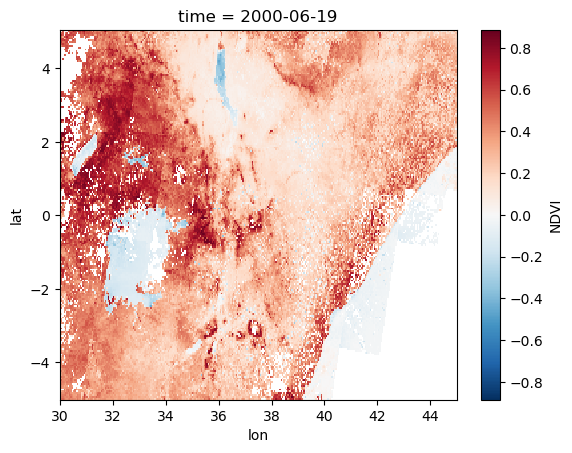

In [42]:
ds_00_filled['NDVI'].isel(time = 170).T.plot()